### Setup for google colab & imports

In [1]:
from google.colab import drive 

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/master thesis/code/Learning-Shapelets"

/content/drive/My Drive/master thesis/code/Learning-Shapelets


In [3]:
#! pip install --user tslearn matplotlib
!pip install tslearn
!pip install shap
import os
## TODO change to 0
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import sys
sys.path.append('/content/gdrive/My Drive/master thesis/code/Learning-Shapelets')

import random
import numpy
import numpy as np
import pandas as pd 
import scipy as sp 
import shap
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler

from tslearn.clustering import TimeSeriesKMeans
import torch
from torch import nn, optim

from src.learning_shapelets import LearningShapelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 7.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 10.5 MB/s eta 0:00:00


### Load UCR-Archive datasets

In [4]:
train_data = np.loadtxt("./demo/data/GunPoint_TRAIN", delimiter=',')
test_data = np.loadtxt("./demo/data/GunPoint_TEST", delimiter=',')


#train_data
X_train = np.expand_dims(train_data[:, 1:],axis=1)
X_train_size = X_train.shape[0]
print(X_train_size)
y_train = train_data[:, 0]-1
print(y_train.shape)

#test_data
X_test = np.expand_dims(test_data[:, 1:],axis=1)
X_test_size = X_test.shape[0]
y_test = test_data[:, 0]-1
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")

50
(50,)
Shape X_train: (50, 1, 150)
Shape X_test: (150, 1, 150)


### Run model

<u>model</u>: The model was implemented by Benedikt Bäumle. Unfortunately, i couldn't find the paper, and therefore it might be not the right choice for the master thesis. 

Nevertheless, the implementation works quite well. For classification, he uses a linear layer with a cross-entropy loss. Strengths of this approach, is that he introduced to penalizers for the loss in order to form the shapelets. One penalizing term in the loss tion pushes the shapelets to be less similar to each other and the other penalizing term pushes the shapelets to be more similar to actuals time series in the training datasets. Both a desirable properties in my planned experiments. 

<u>custom functions:</u> Some of the functions are implemented by myself, others are copied from the demo section of the shapelets implementation. Primarily they are focusing on locating the shortest distance from a shapelet to a timeseries and plotting both. They are used for demonstration purposes mainly.

#### model


In [5]:
def normalize_standard(X, scaler=None):
    shape = X.shape
    data_flat = X.flatten()
    if scaler is None:
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    else:
        data_transformed = scaler.transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    return data_transformed, scaler

def normalize_data(X, scaler=None):
    if scaler is None:
        X, scaler = normalize_standard(X)
    else:
        X, scaler = normalize_standard(X, scaler)
    
    return X, scaler

def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = numpy.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments

def get_weights_via_kmeans(X, shapelets_size, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    """
    segments = sample_ts_segments(X, shapelets_size, n_segments).transpose(0, 2, 1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0, 2, 1)
    return clusters


# normalize training data
X_train, scaler = normalize_data(X_train)

n_ts, n_channels, len_ts = X_train.shape
loss_func = nn.CrossEntropyLoss()
num_classes = len(set(y_train))
# learn 48 shapelets
shapelets_size_and_len = {45:5, 60:5 } #30:15
dist_measure = 'euclidean' #'cosine' #"euclidean"
lr = 4e-3
wd = 1e-4
epsilon = 1e-7
batch_size = 256
shuffle = True
drop_last = False


shapelets_blocks = []
for i, (shapelets_size, num_shapelets) in enumerate(shapelets_size_and_len.items()):
    weights_block = get_weights_via_kmeans(X_train, shapelets_size, num_shapelets)
    shapelets_blocks.append(weights_block)
    
"""
#old:
l1 = 0.05
l2 = 0.15
"""
l1 = 0.1
l2 = 0.1

k = int(0.1 * batch_size) if batch_size <= X_train_size else X_train_size


learning_shapelets_Lr = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=False,
                                       verbose=1,
                                       dist_measure=dist_measure,
                                       l1=l1,
                                       l2=l2,
                                       k=k)

for i, shapelets_block in enumerate(shapelets_blocks):
    learning_shapelets_Lr.set_shapelet_weights_of_block(i, shapelets_block)
    
optimizer = optim.Adam(learning_shapelets_Lr.model.parameters(), lr=lr, eps=epsilon)
learning_shapelets_Lr.set_optimizer(optimizer)

def eval_accuracy(model, X, Y):
    predictions = model.predict(X)
    if len(predictions.shape) == 2:
        predictions = predictions.argmax(axis=1)
        
        print(predictions)
    print(f"Accuracy: {(predictions == Y).sum() / Y.size}")
    return (predictions == Y).sum() / Y.size

epochs = 200
n_epoch_steps =5
losses = []
train_acc_last = 0

losses_acc = []
losses_dist = []
losses_sim = []
train_acc_last_Lr = 0
for _ in range(n_epoch_steps):
    losses_acc_i, losses_dist_i, losses_sim_i = \
        learning_shapelets_Lr.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=drop_last)
    losses_acc += losses_acc_i

    losses_dist += losses_dist_i
    losses_sim += losses_sim_i
    train_acc_current_Lr = eval_accuracy(learning_shapelets_Lr, X_train, y_train)
    if train_acc_current_Lr - train_acc_last_Lr < 1e-3 or train_acc_current_Lr == 1.0:
        break
    train_acc_last_Lr = train_acc_current_Lr

# normalize data
X_test, scaler = normalize_data(X_test, scaler)
test_acc = eval_accuracy(learning_shapelets_Lr, X_test, y_test)
print(test_acc)

Loss CE: 0.10726206749677658, Loss dist: 0.25703689455986023, Loss sim: 0.014886463060975075: 100%|██████████| 200/200 [00:10<00:00, 19.73it/s]


[1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1
 1 1 1 1 0 0 0 1 1 0 1 0 1]
Accuracy: 1.0
[0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1
 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1
 1 0]
Accuracy: 0.9666666666666667
0.9666666666666667


#### custom functions for displaying shapelets

In [6]:
def filterNanFromShapelet(shapelet):
    """
    Filter NaN values from a shapelet.
    Needed for the output of learning shapelets from tslearn, since smaller size shapelets are padded with NaN values.
    Note: Make sure the NaN values are only leading or trailing.
    """
    return shapelet[~numpy.isnan(shapelet)]

def lead_pad_shapelet(shapelet, pos):
    """
    Adding leading NaN values to shapelet to plot it on a time series at the best matching position.
    """
    pad = numpy.empty(pos)
    pad[:] = numpy.NaN
    padded_shapelet = numpy.concatenate([pad, filterNanFromShapelet(shapelet)])
    return padded_shapelet

def torch_dist_ts_shapelet(ts, shapelet, to_cuda=True):
    """
    Use PyTorch to calculate the distance between a shapelet and a time series.
    Implemented via unfolding.
    """
    if not isinstance(ts, torch.Tensor):
        ts = torch.tensor(ts, dtype=torch.float)
    if not isinstance(shapelet, torch.Tensor):
        shapelet = torch.tensor(shapelet, dtype=torch.float)
    if to_cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    if shapelet.dim() == 1:
        shapelet = torch.unsqueeze(shapelet, 0)
    # unfold time series to emulate sliding window
    ts = ts.unfold(1, shapelet.shape[1], 1)
    # calculate euclidean distance over each segment
    dists = torch.sum(torch.cdist(ts, shapelet, p=2), dim=0)
    # filter min dist
    d_min, d_argmin = torch.min(dists, 0)
    return (d_min.item(), d_argmin.item())

def dists_to_shapelet(data, shapelet, to_cuda=True):
    """
    Calculate the distances of a shapelet to a bunch of time series.
    """
    shapelet = filterNanFromShapelet(shapelet)
    dists = []
    for i in range(len(data)):
        dists.append((torch_dist_ts_shapelet(data[i,:], shapelet, to_cuda=to_cuda), i))
    return sorted(dists, key=lambda x: x[0][0])



def plot_shapelet_on_ts_at_i(shapelet, ts, i, title="", axis=None):
    """
    Plot a shapelet on top of a timeseries
    """
    shapelet = filterNanFromShapelet(shapelet)
    padded_shapelet = lead_pad_shapelet(shapelet, i)
    if axis is None:
        pyplot.clf()
        pyplot.rcParams["figure.figsize"] = (23, 6)
        pyplot.plot(ts)
        pyplot.plot(padded_shapelet)
    else:
        axis.plot(ts)
        axis.plot(padded_shapelet)
        
#CUSTOM:

def dists_ts_to_shapelets(ts, shapelets, to_cuda=False):
    """
    Calculate the distances of shapelets to a timeseries
    """
    dists = []
    for i in range(len(shapelets)):
        shapelet = filterNanFromShapelet(shapelets[i])
        dists.append((torch_dist_ts_shapelet(ts, shapelet, to_cuda=to_cuda),i))
    return sorted(dists, key=lambda x: x[0][0])

def plot_ts_and_shapelet(ts,shapelet): 
    sh = filterNanFromShapelet(shapelet)
    dist, pos = torch_dist_ts_shapelet(ts,sh,to_cuda=False)
    padded_shapelet = lead_pad_shapelet(sh,pos)
    pyplot.plot(ts.flatten())
    pyplot.plot(padded_shapelet)
    pyplot.show()


def find_ts_per_class(y_test, searched_class): 
    normal_sort = np.sort(y_test)
    arg_sort = np.argsort(y_test)
    class_x = arg_sort[np.where(normal_sort==searched_class)]
    return class_x

  

#### visualizing classes and shapelets

### Extracting Explanations

#### Custom function for shap explainer

In [7]:
#!pip install shap
%%time
import shap
import scipy as sp

def fu(x, to_cuda=False):
    helper_arr = []
    for i in x:


        if to_cuda:
          sformat = torch.tensor((np.expand_dims(i,axis=0)), dtype=torch.float).cuda()
          #Logits
          outputs = learning_shapelets_Lr.model.linear(sformat).detach().cpu().numpy()
        else: 
          sformat = torch.tensor((np.expand_dims(i,axis=0)), dtype=torch.float)
          #Logits
          outputs = learning_shapelets_Lr.model.linear(sformat).detach().numpy()

        #Cross Entropy
    
        #Sigmoid
        #scores= outputs[0]
        #1/(1+np.exp(-outputs[0]))

        #print(scores)
        #Softmax
        scores = (np.exp(outputs[0]).T / np.exp(outputs[0]).sum(-1)).T
        
        #print(scores)
        #Scipy logits?
        #val = sp.special.logit(scores)
        #print(val)
        helper_arr.append(scores)
        #argmax Class
        #helper_arr.append(np.argmax(learning_shapelets_Lr.model.linear(sformat).detach().cpu().numpy()))
    out = np.array(helper_arr)
    #print("OS", out.shape)
    return out


dist_data = learning_shapelets_Lr.transform(X_train[:100])
dist_data_test = learning_shapelets_Lr.transform(X_test)

CPU times: user 13.9 ms, sys: 8.13 ms, total: 22 ms
Wall time: 42.4 ms


In [8]:
print("Compute Shap values Explainer Obj")
explainer = shap.Explainer(fu, dist_data_test,algorithm='permutation')#alogrithm='linear')
explanation_obj = explainer(dist_data)


Compute Shap values Explainer Obj


Permutation explainer: 51it [03:22,  4.13s/it]


In [9]:
print("Compute Shapvalues with Kernel Explainer")
kernel_explainer = shap.KernelExplainer(fu, dist_data[:30],link='logit')
shap_values = kernel_explainer.shap_values(dist_data, nsamples=500)

Compute Shapvalues with Kernel Explainer


  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
def explanation_for_class(explanation_obj,yclass): 
  shp_vals = explanation_obj.values[:,:,yclass]
  shp_bvals = explanation_obj.base_values[:,yclass]
  data = explanation_obj.data
  return shap.Explanation(shp_vals, base_values=shp_bvals, data=data)


### Visualizations 

The summary plot shows global average attribution of features towards a prediction. As we can see in the following graphic, some features account significantly more towards a predicition outcome in general. 

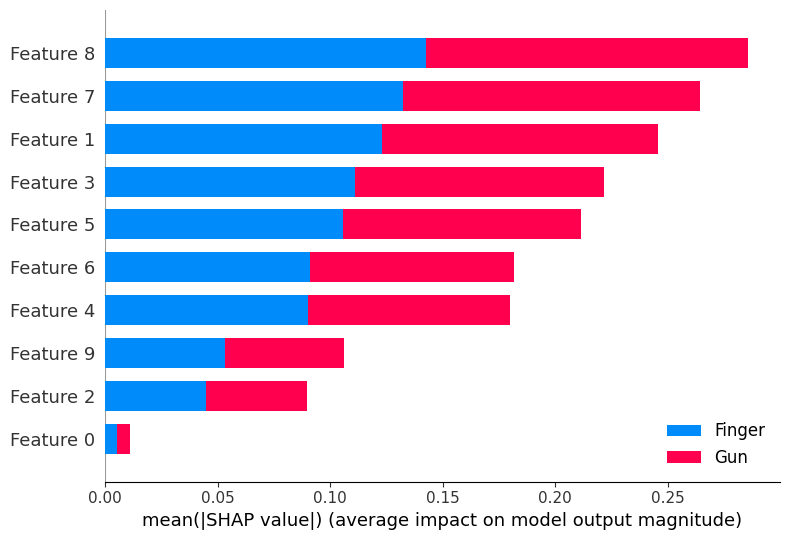

In [19]:
#For explanation obj
shap.summary_plot(list(explanation_obj.values.transpose(2,0,1)), dist_data, plot_type="bar", class_names= ["Gun","Finger"])
#For KernelExplainer (i recieved the same result)
#shap.summary_plot(shap_values, dist_data, plot_type="bar", class_names= ["Gun","Finger"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


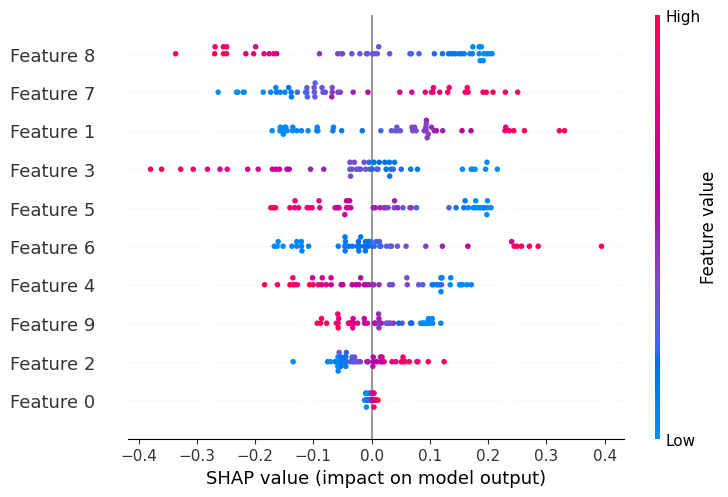

In [20]:
class0 =  explanation_for_class(explanation_obj,0)
shap.plots.beeswarm(class0)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


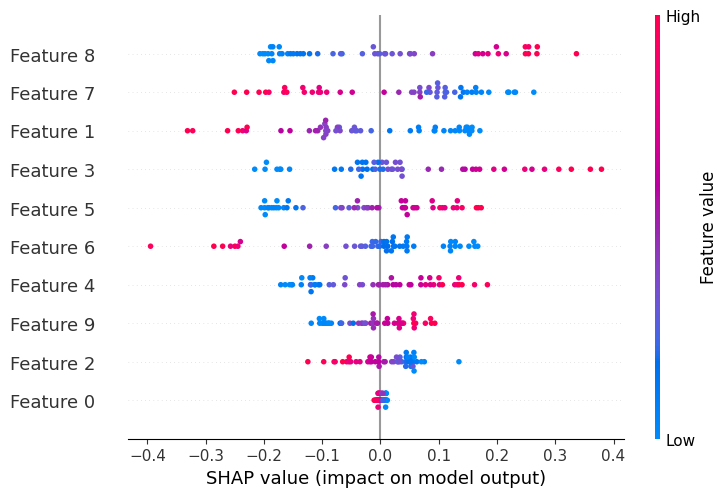

In [34]:
class1 = explanation_for_class(explanation_obj,1)
shap.plots.beeswarm(class1)

In [14]:
def logodd_to_prob(log_odd_prob, printt=True):
  prob = np.exp(log_odd_prob) / (1 + np.exp(log_odd_prob))
  check_prob = np.exp(-log_odd_prob) / (1 + np.exp(-log_odd_prob))
  add = prob+check_prob
  if printt : print(f"The probability for this class is {prob}, counter_prob is {check_prob}, and they add up to {add}")
  return prob

In [15]:
def highlight(df):
    return ['background-color: green'] * len(df)

subset = ['mean']
mean_val = pd.DataFrame(dist_data).describe().T

mean_val.style.apply(highlight,subset=subset)

,count,mean,std,min,25%,50%,75%,max
0,50.000000,2.010041,1.217520,0.349849,0.750635,2.038875,3.010246,4.169551
1,50.000000,2.433874,2.041030,0.213972,0.567378,2.306533,3.366251,7.305621
2,50.000000,2.539018,0.656559,1.629838,2.013470,2.375952,2.948301,4.796773
3,50.000000,2.353387,1.436348,0.481670,1.348771,2.070206,3.347096,5.748131
4,50.000000,2.232164,0.880462,0.802592,1.337034,2.335132,2.889027,4.288491
5,50.000000,2.402908,1.247229,0.677813,1.189487,2.514112,3.207504,5.424649
6,50.000000,2.946490,2.128409,0.843320,1.775006,2.269216,3.105142,8.487964
7,50.000000,3.561857,1.518780,1.601870,2.249739,3.086984,5.197926,6.305785
8,50.000000,2.978595,1.865626,0.875649,1.404085,2.579544,4.678066,7.025013
9,50.000000,2.240088,1.411463,0.235260,1.040553,2.302505,3.224652,5.909049


In [38]:
from collections import Counter

test_array = []
for i in explanation_obj.values[:,:,1]:
  test_array.append(np.argmax(np.abs(i))) 

print(Counter(test_array), len(test_array))

Counter({8: 12, 3: 11, 5: 9, 7: 8, 1: 5, 6: 5}) 50


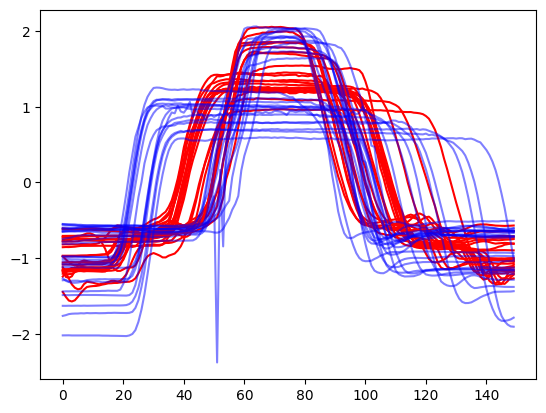

In [17]:
c0 = find_ts_per_class(y_train,0)
c1 = find_ts_per_class(y_train,1)

for i in c0: 
  plt.plot(X_train[i].T, color="red")

for i in c1: 
  plt.plot(X_train[i].T, color="blue",alpha=0.5)

In [18]:
#print(np.argsort(class0.values[2]))
#print(y_train)
def compare_relationship(distances,shapelet_values,summary_df,yclass=1):
  #print(len(distances))
  current=0; exp_lim = 0.85
  pos_impact = []; pos_cont = 0
  neg_impact = []; neg_cont = 0
  for idx,shapelet in enumerate(shapelet_values):
    #print(summary_df.iloc[idx]["mean"])
    if distances[idx] < summary_df.iloc[idx]["mean"]:
      pos_cont += shapelet[1]
    else: 
      print(shapelet[1])
      neg_cont += shapelet[1]
    #print(summary_df.iloc[idx]["mean"])
  print(pos_cont, neg_cont)
    #break


compare_relationship(dist_data[2],explanation_obj.values[2], mean_val)
#print(explanation_obj.data)


0.0015663511141294393
-0.002295258138509899
-0.04501625943560728
-0.04842828048193031
-0.016766923068156272
-0.2900818551450563 -0.11094037001007433


In [ ]:
from collections import Counter

l = []
d = []
c = []
for i in range(len(explanation_obj.values)): 
  #print(y_train[i])
  #print(values[:,1])
  for arg in np.argsort(explanation_obj.values[i][:,int(y_train[i])])[::-1]:
    if dist_data[i][arg] < 2:
      l.append(arg)
      d.append(dist_data[i][arg])
      c.append(explanation_obj.values[i][:,int(y_train[i])][arg])
      break

  #np.argmax(explanation_obj.values[2])


#print(Counter(l),l)
#print(l.index(1))
#print(d)
indexes = np.where(np.array(c)<0.1)
#print(indexes)

for ind in indexes[0]:
  #print(ind)
  l[int(ind)] = 99

print(l)

[3, 3, 5, 5, 3, 3, 2, 99, 99, 8, 8, 8, 99, 8, 3, 8, 3, 3, 8, 99, 1, 8, 8, 99, 5, 99, 8, 8, 99, 99, 1, 2, 99, 5, 3, 5, 2, 3, 99, 2, 3, 8, 8, 8, 99, 3, 5, 4, 5, 99]


In [ ]:
c = 0


for s in d: 
  if s < 1: 
    c += 1

d=np.array(d)
print(np.where(d<1))
print(c/50)

(array([ 0,  1,  2,  3,  5,  9, 10, 11, 13, 15, 16, 17, 18, 20, 21, 22, 24,
       26, 27, 30, 33, 34, 35, 40, 41, 42, 43, 45, 46, 48]),)
0.6


In [ ]:
print(len(l))
print(l)
print(d)
print(c)

50
[3, 3, 5, 5, 3, 3, 2, 2, 2, 8, 8, 8, 8, 8, 3, 8, 3, 3, 8, 2, 1, 8, 8, 2, 5, 3, 8, 8, 2, 9, 1, 2, 2, 5, 3, 5, 2, 3, 2, 2, 3, 8, 8, 8, 2, 3, 5, 4, 5, 2]
[0.40720433, 0.24197872, 0.7191599, 0.5504002, 0.84819496, 0.43283206, 0.39830825, 1.9626011, 1.2106351, 0.6880131, 0.70141935, 0.5470842, 1.2037653, 0.6211828, 0.33993074, 0.66282916, 0.3491426, 0.5598642, 0.7316402, 0.88848513, 0.5872544, 0.5075871, 0.5402183, 1.3182393, 0.7612228, 1.4130714, 0.6489109, 0.6206821, 0.90318465, 1.9871135, 0.6015292, 0.6444188, 1.4871415, 0.7072012, 0.40235084, 0.68424076, 0.4353169, 0.35859662, 1.2000058, 0.70290524, 0.35759795, 0.73737127, 0.4181467, 0.4582649, 0.8933919, 0.33083424, 0.7910536, 1.3306015, 0.8878323, 0.6876519]
[0.20547777262154543, 0.23087865244017375, 0.22088205160190258, 0.27194019006236625, 0.15909723630826406, 0.21840156190579496, 0.13441412703184433, 0.02923903395489104, 0.08411724825560088, 0.14957369166111617, 0.15176478193349247, 0.17055515653175132, 0.09792700098861636, 0.17

In [36]:
o1=[]; o2=[]; 
for s,o in zip(l,y_train): 
  if o == 0: 
    o1.append(s)
  else: 
    o2.append(s)

print(Counter(o1),Counter(o2))

NameError: ignored

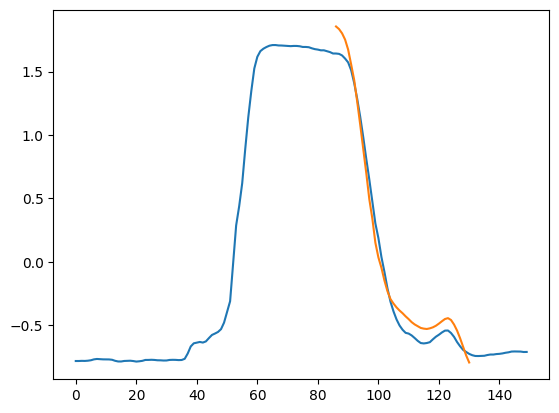

In [33]:
import matplotlib.pyplot as plt

shapelets_Lr=learning_shapelets_Lr.get_shapelets()
#print(y_train[14],l[14],d[14])
plot_ts_and_shapelet(X_train[2], shapelets_Lr[3])

0.0
0.9999999999999998


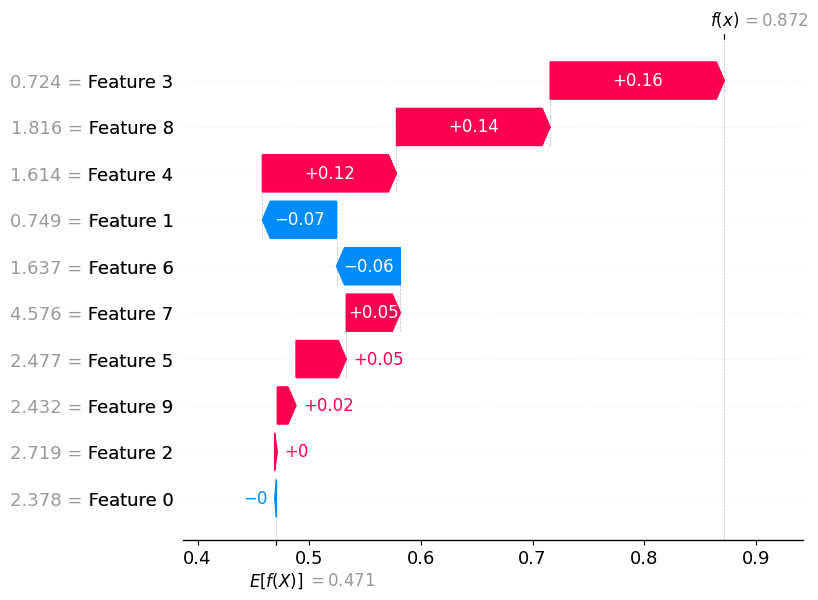

In [35]:
# Needs revision: 
ts  = 2
print(y_train[ts])
#exp = shap.Explanation(shap_values[:,:,2], shap_values.base_values[:,2], dist_data, feature_names=None)
exp = shap.Explanation(explanation_obj.values[:,:,0], explanation_obj.base_values[:,0], explanation_obj.data, feature_names=None)
print(sum(np.sort(abs(exp[ts].values)/sum(abs(exp[ts].values)))[::-1][:20]))
shap.plots.waterfall(exp[ts], max_display=10)

In [ ]:
shap.initjs()
#print(pd.DataFrame(dist_data[35]).T)
#print(shap_values.)
shap.force_plot(explainer.expected_value, shap_values, pd.DataFrame(dist_data[35]).T)

In [ ]:
shap.summary_plot(shap_values, dist_data)

In [ ]:
#exp = shap.Explanation(shap_values[:,:,2], shap_values.base_values[:,2], dist_data, feature_names=None)

In [ ]:
shap.summary_plot(shap, X_test)

In [ ]:
shap.plots.waterfall(exp[0], max_display=14)

In [ ]:
#### Old code to be revised
#shap.summary_plot(shap_values_exp1, dist_data[:0], plot_type="bar", class_names= ["Gun","Finger"], feature_names = ["s1","s2","s3","s4","s5"])
def logodd_to_prob(log_odd_prob, printt=True):
  prob = np.exp(log_odd_prob) / (1 + np.exp(log_odd_prob))
  check_prob = np.exp(-log_odd_prob) / (1 + np.exp(-log_odd_prob))
  add = prob+check_prob
  if printt : print(f"The probability for this class is {prob}, counter_prob is {check_prob}, and they add up to {add}")
  return prob

ts = 48
outcome = int(y_test[ts])
print(outcome)
import pandas as pd
shap.initjs()
shap_values_exp1 = kernel_explainer.shap_values(dist_data[ts], nsamples=500)
#print(shap_values_exp1,y_test[35])
shap.force_plot(kernel_explainer.expected_value[outcome], shap_values_exp1[outcome], pd.DataFrame(dist_data[ts]).T)